In [1]:
# custom module
import topodisc as td

import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, mean

import pandas as pd
from dataclasses import dataclass
import itertools

import warnings
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import mean_squared_error

warnings.simplefilter("error", OptimizeWarning)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

def save_pdf(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.pdf')

Confirm tilt calculations work as expected.

/Users/henry/GEOL192/GEOL192-Manuscript/topodisc.py:112: RuntimeWarning: divide by zero encountered in double_scalars
  argument = sin(beta2) * sin(sl2) / sin(beta1)


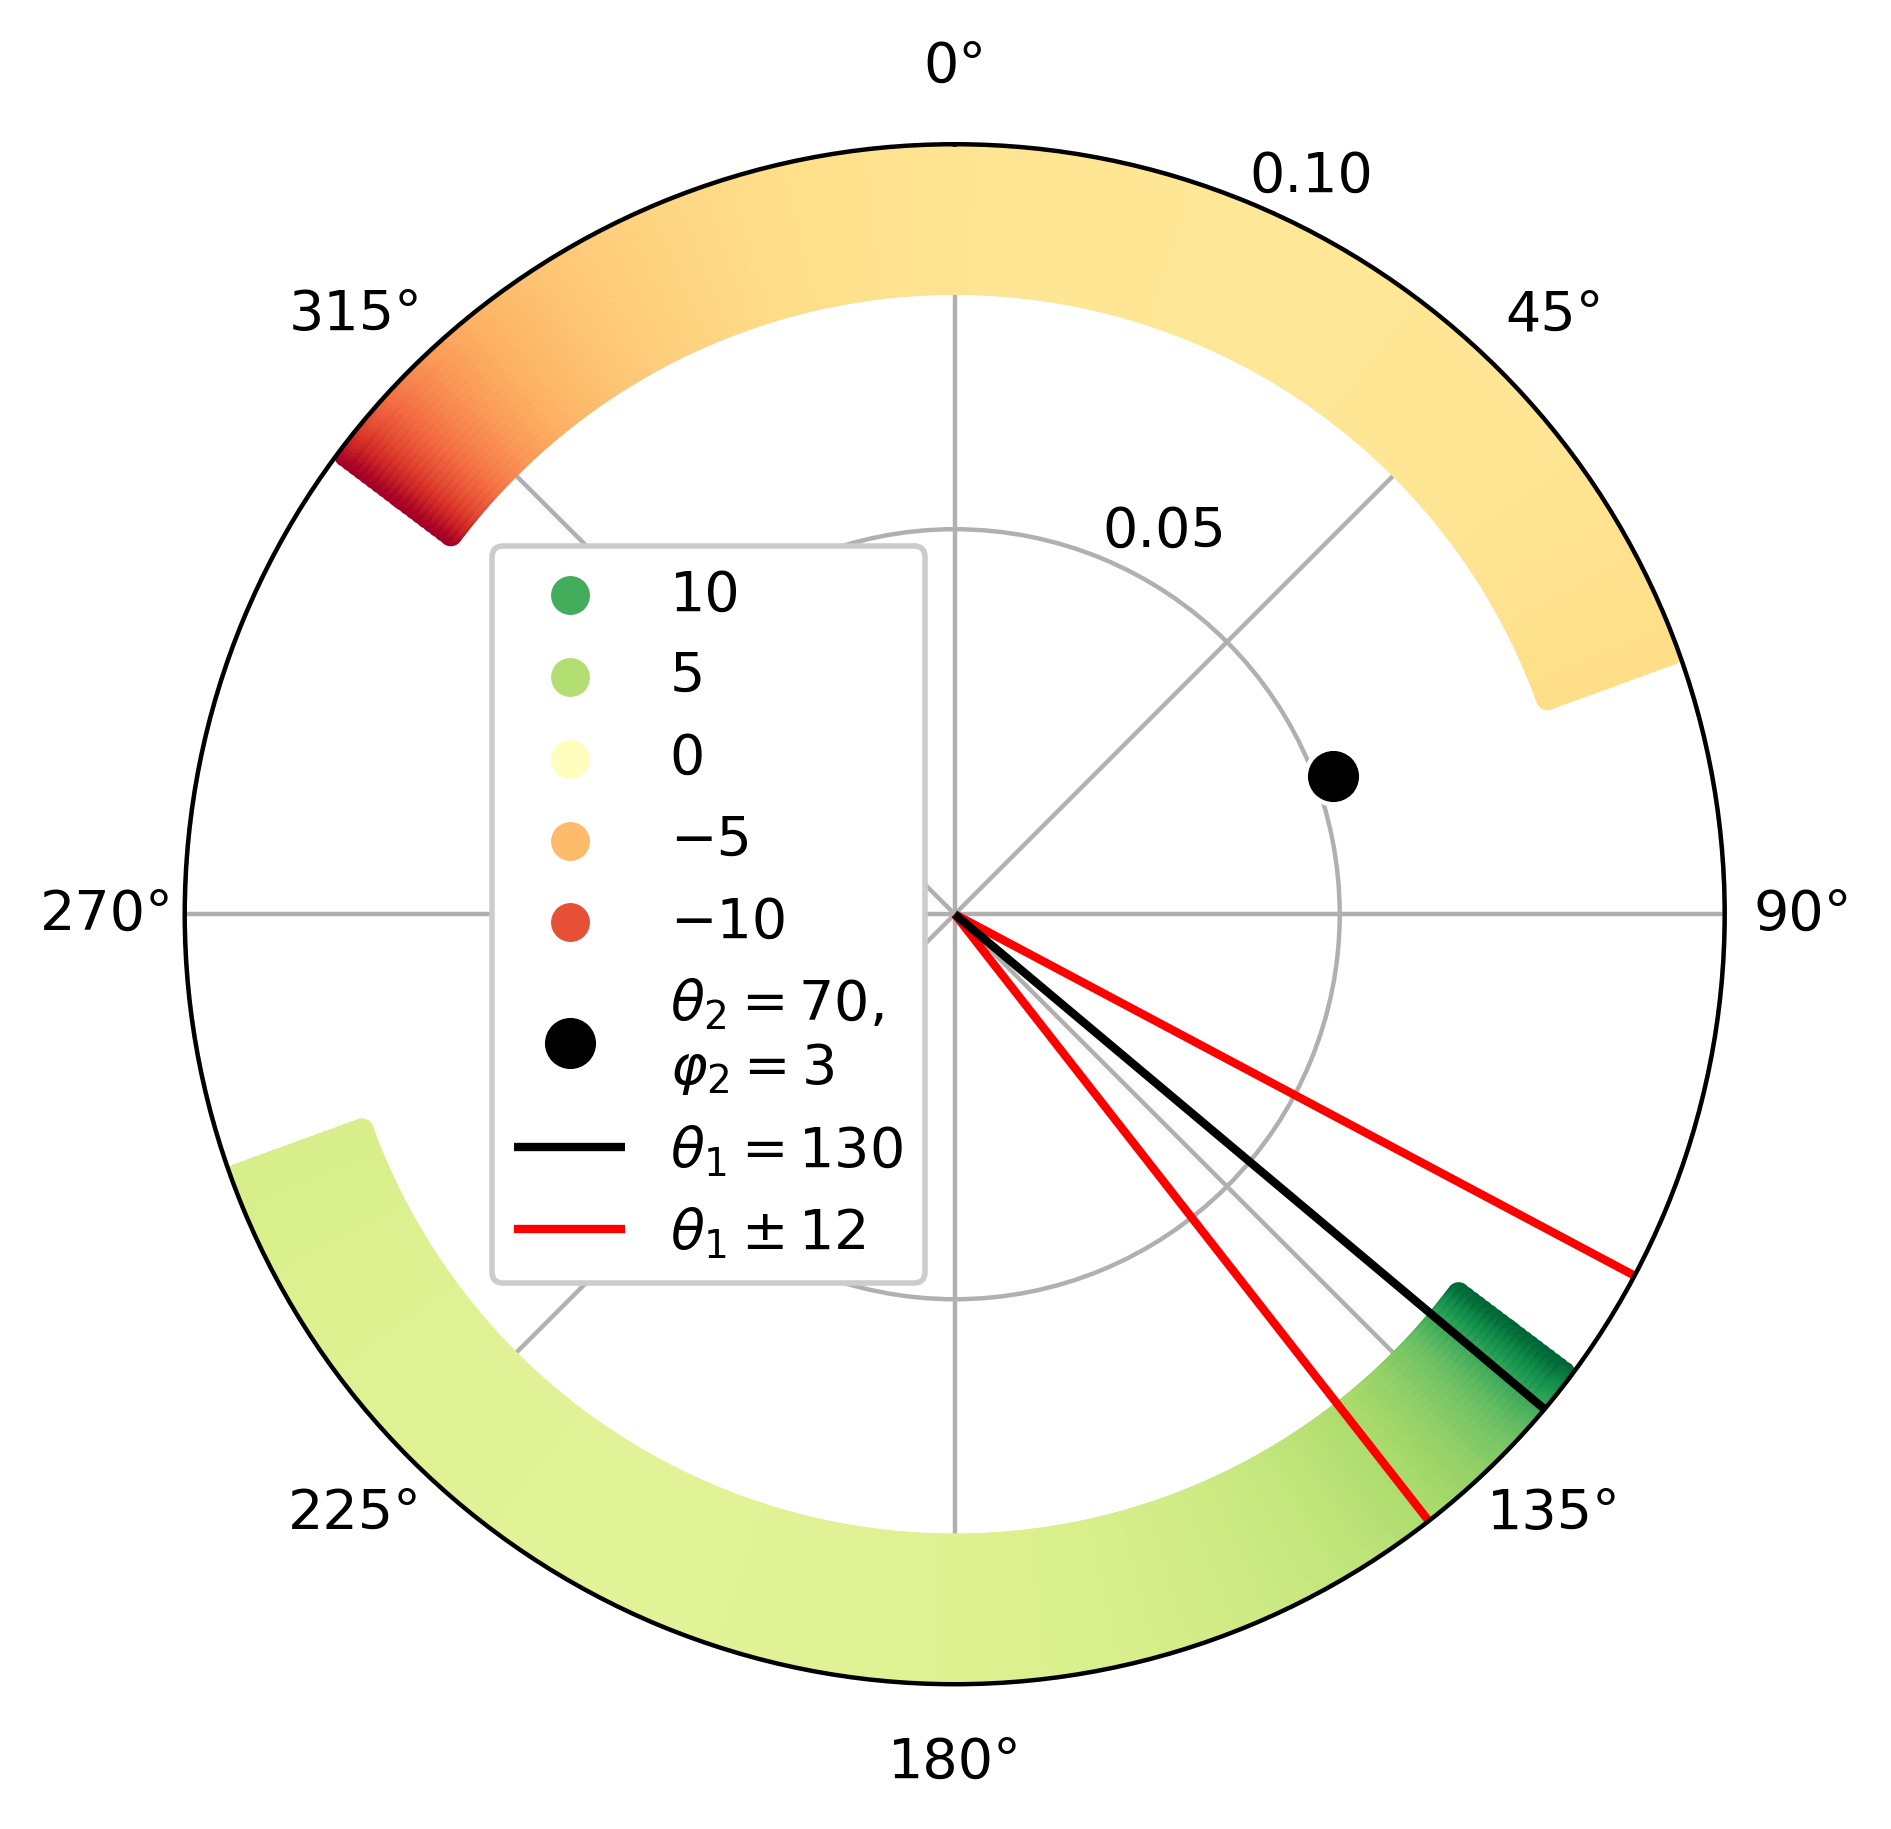

In [8]:
paleo_azimuth_uncertainty = 12

td.tilt_check(
    test_az1=130,
    test_az2=70,
    test_sl2=3,
    paleo_azimuth_uncertainty=paleo_azimuth_uncertainty,
    max_abs_tilt=15,
    legend_position=(.34, .5),
    plot_radius=.1
)
#td.tilt_check(az1=130, az2=230, sl2=2, legend_position=(0.34, 0.7))

## Map Data

In [10]:
map_path = "../GEOL192-GIS/data/"

centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index('sID')

cIDs = centers.index.tolist()
sIDs = samples.index.tolist()

feature_sIDs = {
    'flow': samples.index[samples['FEATURE'] == 'flow'].tolist(),
    'channel': samples.index[samples['FEATURE'] == 'channel'].tolist(),
}

POP_A_sIDs = [
    198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493
]

POP_B_sIDs = [
    193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549
]

POP_C_sIDs = [
    529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543
]

POP_ABC_sIDs = POP_A_sIDs + POP_B_sIDs + POP_C_sIDs

POP_E_sIDs = samples.index[samples['LON'] > -133.16554044].tolist()
POP_W_sIDs = samples.index[samples['LON'] < -133.16554044].tolist()


pop_all = td.Population(name='all', sIDs=sIDs)
pop_flow = td.Population(name='flow', sIDs=feature_sIDs['flow'])
pop_channel = td.Population(name='channel', sIDs=feature_sIDs['channel'])

pop_a = td.Population(name='A', sIDs=POP_A_sIDs)
pop_b = td.Population(name='B', sIDs=POP_B_sIDs)
pop_c = td.Population(name='C', sIDs=POP_C_sIDs)

pop_e = td.Population(name='EAST', sIDs=POP_E_sIDs)
pop_w = td.Population(name='WEST', sIDs=POP_W_sIDs)



pop_abc = td.Population(name='ABC', sIDs=POP_ABC_sIDs)

In [49]:
len(pop_e.sIDs)

287

Calculate tilt (etc.) for each sample, repeat for each center. Full dataset from which to pull subsets later.

In [3]:
# ensure default values before computing results for analytical fit
td.MAX_EPV = 7e22
td.TEST_D = 20_000
td.AZ1_UNCERTAINTY = 7

centers_calc = {
    cID: td.make_center(cID, centers, samples, td.AZ1_UNCERTAINTY) for cID in cIDs
}

In [72]:
td.minimum_tilt

<function topodisc.minimum_tilt(beta1_deg, beta2_deg, slope_deg, paleo_azimuth_uncertainty=7)>

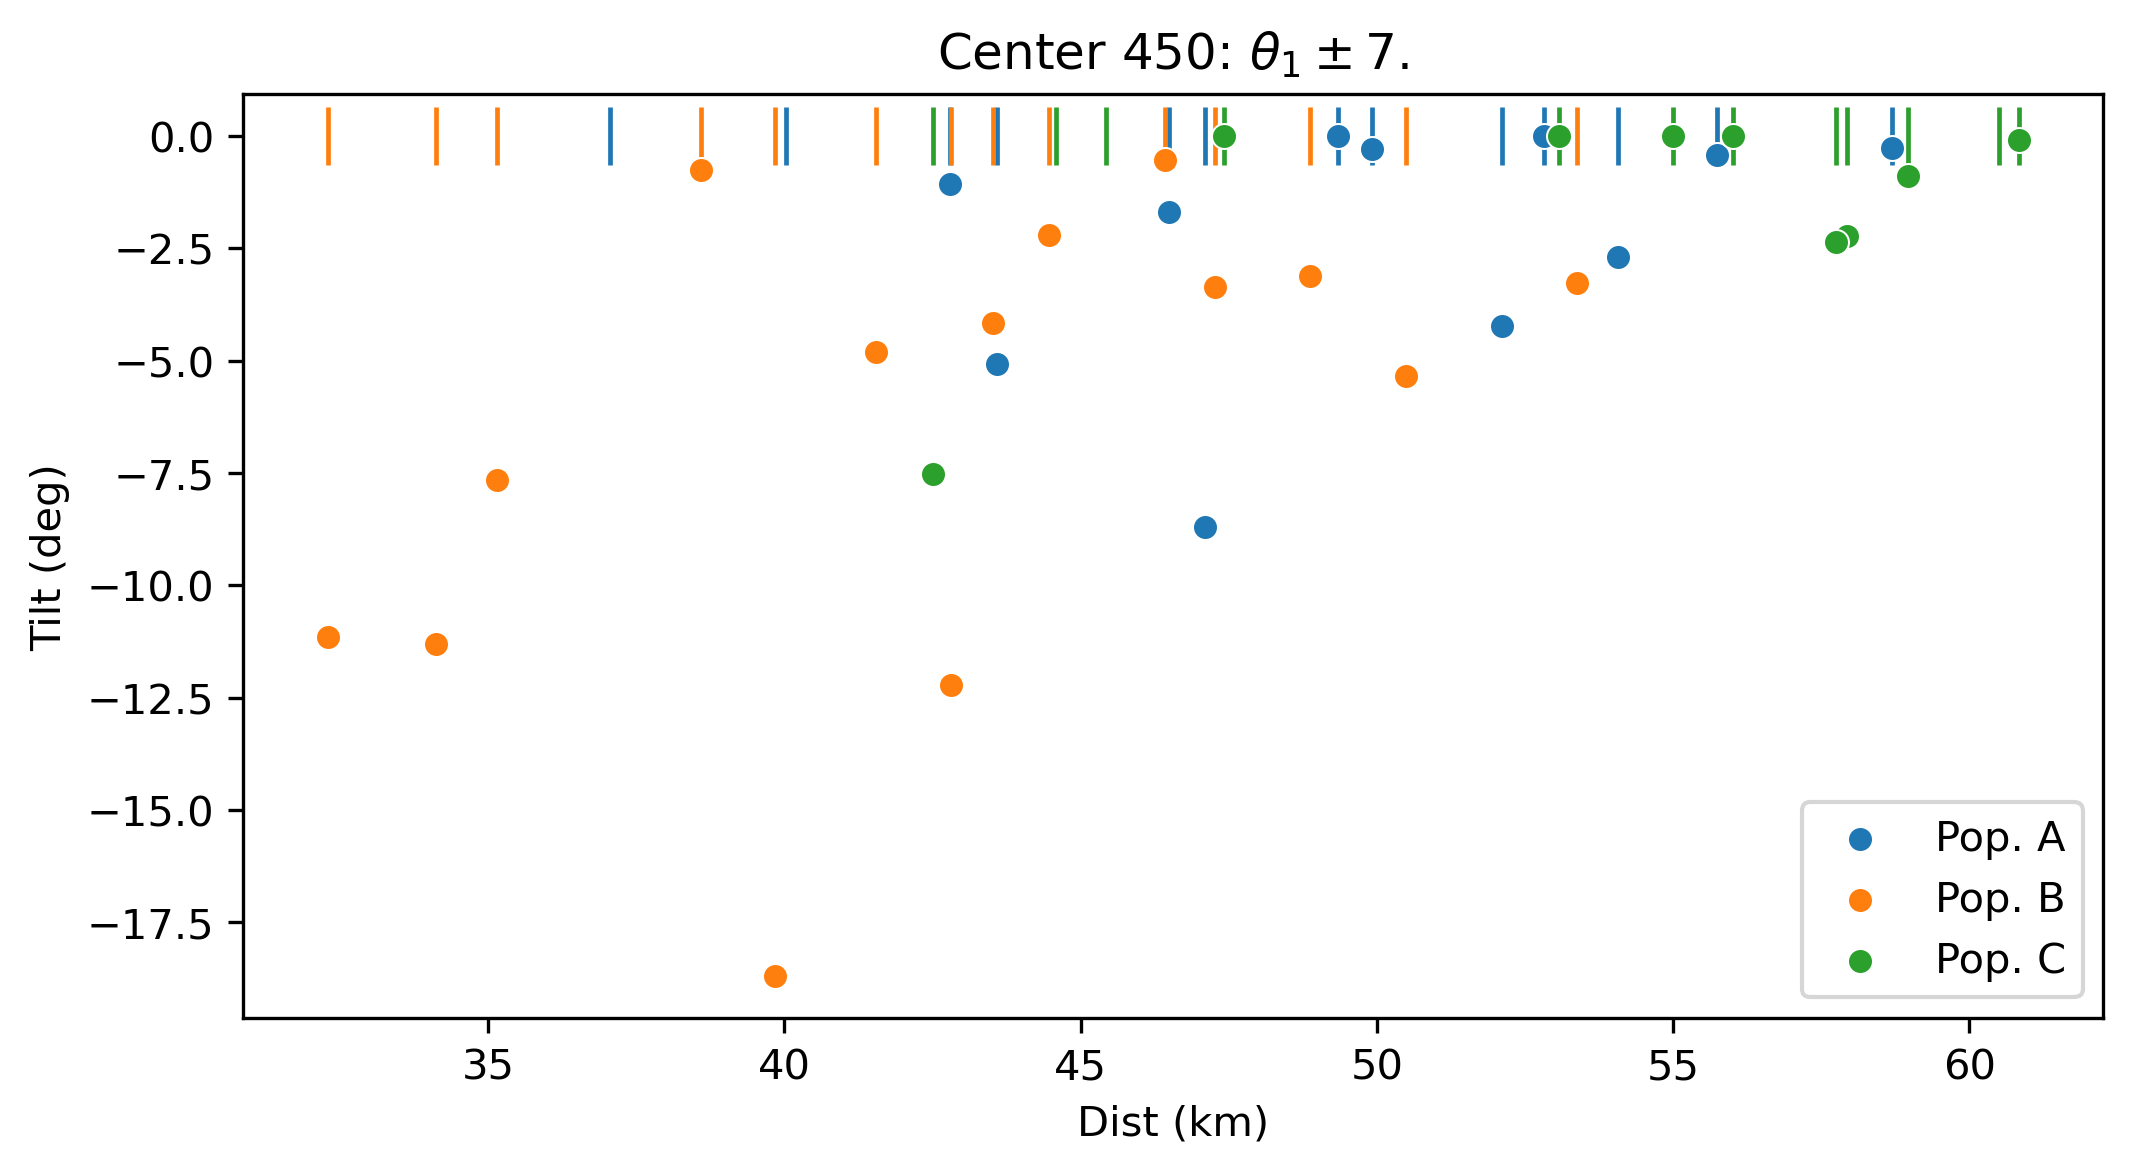

In [15]:
cID = 450

paleo_azimuth_uncertainty = 7

plt.figure(figsize=(8, 4), dpi=300)

center_450 = td.make_center(cID, centers, samples, paleo_azimuth_uncertainty=paleo_azimuth_uncertainty)

center_450.plot_tilt(
    [pop_a, pop_b, pop_c],
    exclude_untiltable=False
)

plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

# plt.title(f'Center {cID}: $\\theta_1 \pm {paleo_azimuth_uncertainty}.$')

# plt.xlim(0, 60)
# plt.ylim(-10,10)

plt.legend(loc='lower right')

# save_pdf('results/center-311-scatter-all') # if exclude_untiltable = False
# save_pdf('results/center-311-scatter-no-outliers') # if exclude_untiltable = True

(0.0, 150.0)

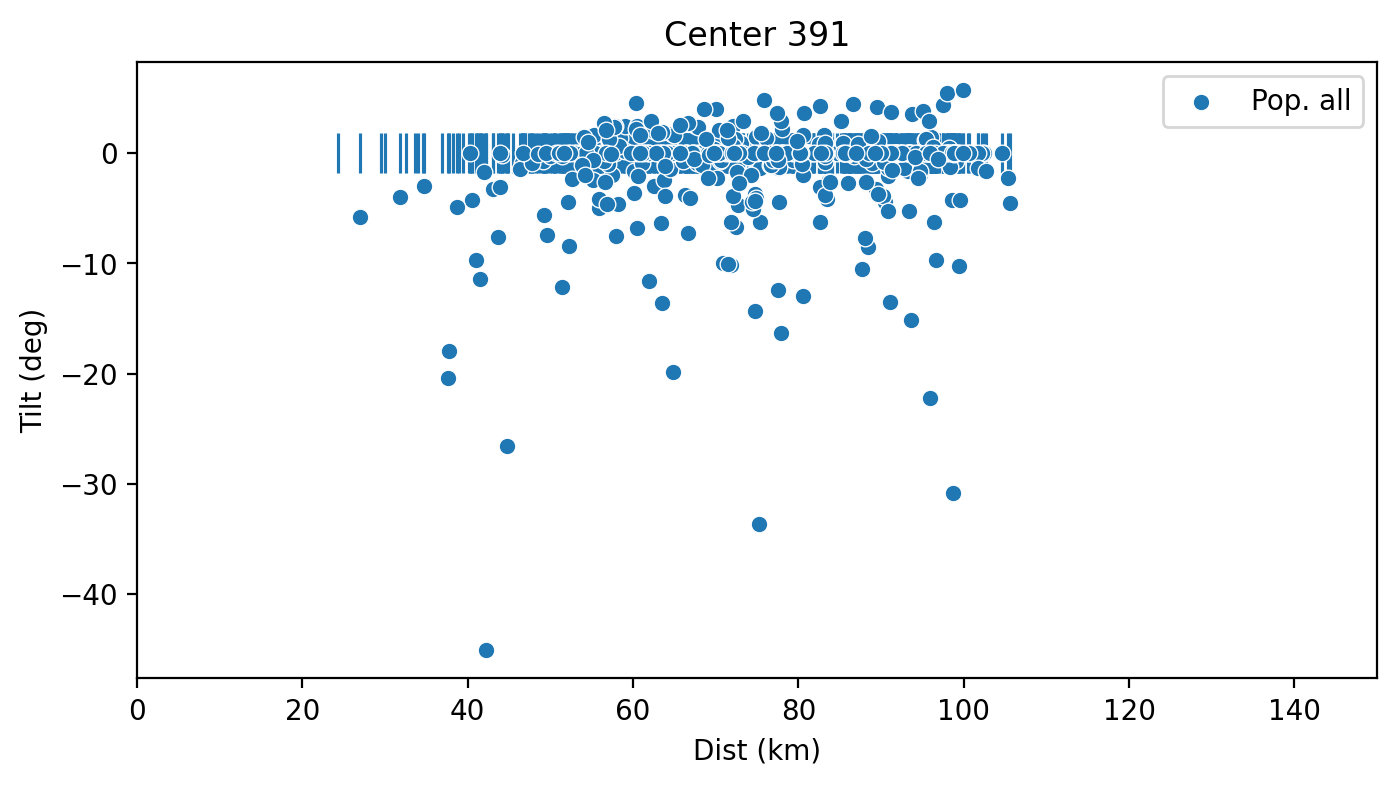

In [27]:
cID = 450

plt.figure(figsize=(8, 4), dpi=200)

td.MAX_EPV = 10**25.703412
td.TEST_D = 344899
# td.plot_envelope(has_label=False)

centers_calc[cID].plot_tilt(
    [pop_all],
    exclude_untiltable=False
)

plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

plt.title(f'Center {cID}')

plt.xlim(0, 150)
# plt.ylim(-1,6)

# save_pdf(f'results/center-{cID}-scatter-all') # if exclude_untiltable = False
# save_pdf(f'results/center-{cID-scatter-no-outliers') # if exclude_untiltable = True

Define criteria for evaluation.

Define criteria and perform evaluation. This takes less than two minutes on my machine.

In [50]:
criteria = [
    #td.Criterion(td.summit_score, pop_all),
    #td.Criterion(td.summit_score, pop_flow),
    #td.Criterion(td.summit_score, pop_channel),
    #td.Criterion(td.frac_tiltable, pop_a),
    #td.Criterion(td.frac_tiltable, pop_b),
    #td.Criterion(td.frac_tiltable, pop_c),
    #td.Criterion(td.frac_tiltable, pop_all),
    #td.Criterion(td.inflation_score, pop_all),
    td.Criterion(td.frac_tiltable, pop_e),
    td.Criterion(td.inflation_score, pop_e),
    td.Criterion(td.frac_tiltable, pop_w),
    td.Criterion(td.inflation_score, pop_w),
]

scores = {}
score_names = []

# note: will get score name out of order if any criteria throw errors, so those need to be handled in each evaluation function
for cID in cIDs:

    center = centers_calc[cID]
    centers_eval = []

    for crit in criteria:
        center_crit_scores = td.evaluate_center(center, crit)

        for key, val in center_crit_scores.items():
            centers_eval.append(val)

            full_score_name = f'{crit.pop.name}_{key}'

            if full_score_name not in score_names:
                score_names.append(full_score_name)
                
    scores[cID] = centers_eval

centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)
centers_eval_no_infs = centers_eval.replace([np.inf, -np.inf], np.nan)

In [51]:
centers_eval_no_infs

/Users/henry/opt/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/henry/opt/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,EAST_frac_tiltable,EAST_log10_epv,EAST_epv_is_positive,EAST_depth,EAST_rmse,WEST_frac_tiltable,WEST_log10_epv,WEST_epv_is_positive,WEST_depth,WEST_rmse
1,0.864111,26.529690,True,6.859838e+05,2.815977,0.924460,NaN,NaN,NaN,NaN
2,0.864111,24.294127,True,1.735021e+05,3.430916,0.920863,NaN,NaN,NaN,NaN
3,0.857143,31.953911,False,1.837186e+07,4.894413,0.899281,NaN,NaN,NaN,NaN
4,0.860627,24.915279,True,2.700471e+05,2.991379,0.892086,NaN,NaN,NaN,NaN
5,0.860627,NaN,NaN,NaN,NaN,0.895683,24.116099,True,107665.806510,4.475427
...,...,...,...,...,...,...,...,...,...,...
777,0.923345,25.652792,False,2.086036e+05,11.478225,0.978417,24.841511,False,143052.173478,4.058894
778,0.912892,25.754743,False,2.327864e+05,10.190061,0.982014,24.793586,False,133313.974018,4.295291
779,0.898955,24.700189,False,1.042908e+05,8.232807,0.982014,24.912249,False,145350.458547,4.888299
780,0.912892,24.434612,False,8.740605e+04,4.719218,0.985612,25.014283,False,154599.772693,5.849083


Write evaluation to disk.

In [52]:
centers_eval_no_infs.to_csv(
    f'{map_path}centers_eval_EW.csv',
    index_label='cID'
)

## Model data

Define parameter combinations.

In [61]:
grav_topo_test_params = {
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
}

mogi_shallow_oblate_test_params = {
    "depth": [15_000, 20000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
}

mogi_test_params = {
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
}

In [26]:
coarse_params_shallow = {
    "depth": [4_000, 8_000, 12_000],
    "radius": [5_000, 10_000],
    "aspect": [0.2, 0.5, 0.7],
    "pmult": [-1, -0.5, 0.5, 1],
    "grav": [False],
    "topo": [True],
}

coarse_params_deep = {
    "depth": [16_000, 20_000, 24_000], # 25
    "radius": [20_000, 25_000, 30_000], # 5
    "aspect": [0.2, 0.3, 0.5],
    "pmult": [-1, 1, 2],
    "grav": [False],
    "topo": [True],
}

full_coarse_sweep = td.ParamSweep(
    td.unpack_param_combinations(coarse_params_shallow) 
    + td.unpack_param_combinations(coarse_params_deep)
)

In [6]:
len(full_coarse_sweep.models)

153

In [27]:
oblate_deflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [25_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deep_deflation_params = {
    "depth": [12_000, 14_000, 16_000], # 25
    "radius": [24_000, 26_000, 28_000, 30_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.75, -1, -1.25, -1.5, -1.75],
    "grav": [False],
    "topo": [True],
}

oblate_inflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [10_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deflation_sweep = td.ParamSweep(
    td.unpack_param_combinations(oblate_deflation_params)
    + td.unpack_param_combinations(oblate_deep_deflation_params)
)

model.params['depth']=8000
model.params['radius']=26000
model.params['aspect']=0.1
model.params['pmult']=-1.25


Text(0.5, 1.0, 'Center 310')

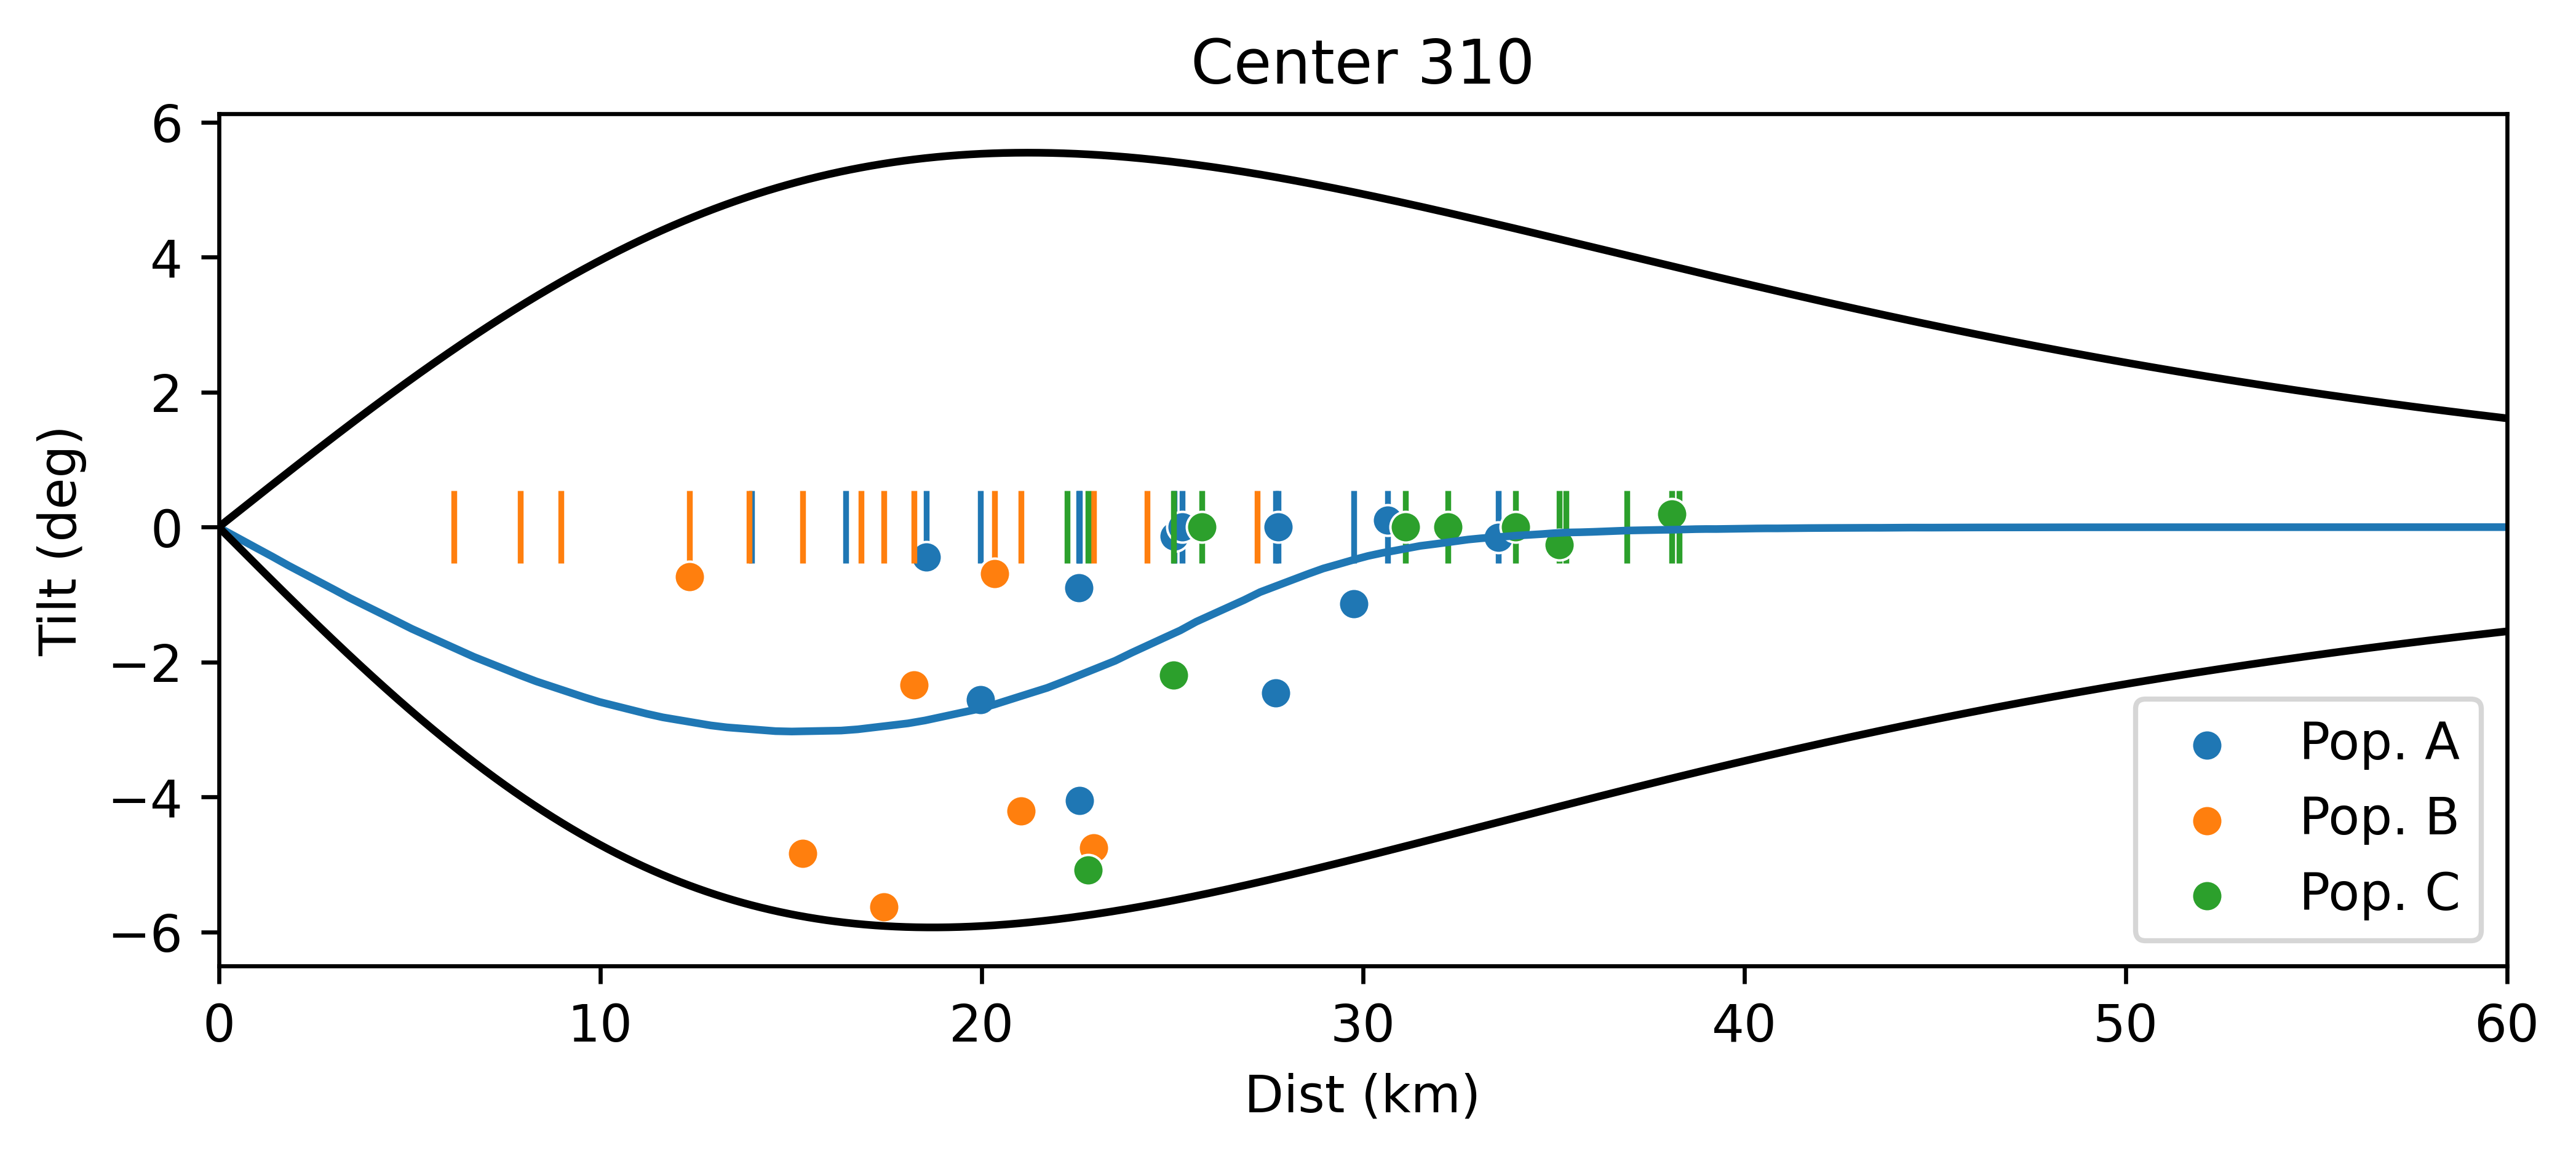

In [45]:
cID = 310

oblate_deflation_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    pops=[pop_a, pop_b, pop_c],
    tiltable_only=True
    )

plt.figure(figsize=(8,3), dpi=600)

for model in oblate_deflation_sweep.models[:1]:
    print(f"{model.params['depth']=}")
    print(f"{model.params['radius']=}")
    print(f"{model.params['aspect']=}")
    print(f"{model.params['pmult']=}")
    model.plot_numerical_tilt()

plt.ylabel('Tilt (deg)')
plt.xlabel('Dist (km)')
plt.xlim(0, 50)

# make a new higher cutoff function to use for excluding untiltables

td.MAX_EPV = 1e24
td.TEST_D = 40_000
td.plot_envelope(has_label=False)

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c],
    exclude_untiltable=True
)

plt.legend(loc='lower right')
plt.xlim(0,60)

plt.title(f'Center {cID}')

In [16]:
len(oblate_deflation_sweep.models)

540

In [1]:
possible_collapse_center_cIDs = [310, 311]

for cID in possible_collapse_center_cIDs:
    oblate_deflation_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    pops=[pop_a, pop_b, pop_c],
    tiltable_only=True
    )

    model = oblate_deflation_sweep.models[0]

    print(f"{cID}: {model.params =}")

    

NameError: name 'oblate_deflation_sweep' is not defined

In [47]:
df = pd.DataFrame({
    'a':[1,2],
    'b':[3,np.nan]
})

In [52]:
len(df[df['b'].notnull()])

1